# Application: Few Body Problem

Consider a system of masses (e.g., stars) interacting gravitationally.  Each
experiences a gravitational force from the others.  For $N$ masses,
there are $N(N-1)/2$ interactions, which means that the work involved
in evaluating all of the forces scales like $\mathcal{O}(N^2)$ for
large $N$.

We'll solve the "few body" problem under the simplifying assumption
that all of the motion is in the $x-y$ plane.

The evolution equations for the system are:

$$\frac{d^2 {\bf x}_i}{dt^2} = \sum_{j = 1; j \ne i}^{N}
                G m_j \frac{{\bf x}_j - {\bf x}_i}{|{\bf x}_j - {\bf x}_i|^3}$$


where $i = 1, 2, \ldots, N$, and ${\bf x}_i = (x_i, y_i)$ are the coordinates
of star $i$.  We can write this as a system of first-order ODEs by
introducing the velocity,

$${\bf v}_i = \frac{d{\bf x}_i}{dt}$$

There is one additional bit&mdash;if two stars get too close, then the
denominator can become very small, and this will greatly impact our
timestep.  The standard way of dealing with this is to introduce a
[softening
length](https://en.wikipedia.org/wiki/N-body_simulation#Softening),
changing the equations to:

\begin{align*}
\frac{d{\bf x}_i}{dt} &= {\bf v}_i \\
\frac{d{\bf v}_i}{dt} &= \sum_{j = 1; j \ne i}^{N}
                G m_j \frac{{\bf x}_j - {\bf x}_i}{(|{\bf x}_j - {\bf x}_i|^2 + \epsilon^2)^{3/2}}
\end{align*}

where $\epsilon$ is chosen to be small.

## Implementation

Here's an implementation for $N = 3$.  Extending it to more stars is
straightforward.  We work in units with $G = 1$.

https://github.com/zingale/computational_astrophysics/tree/main/examples/few_body

The flow is basically the same as the orbit RK4 solver we saw.  We now store the history in a formal like:

```
stars = [(State, State, State), (State, State, State), ...]
```

where `State` is a container that holds a single star's position + velocity (and knows how to add them and multiply by a scalar).

Each element in `stars` is a tuple containing all of the star `State`s at a single instance in time.

The C++ version is essentially the same, taking the form:

```
std::vector<std::vector<State>> stars;
```

So each element of `stars`, like `stars[0]` is a `vector` of `State` objects, with one for each star.

<div class="alert alert-block alert-info">

**Next Steps:**
    
You should try extending this to an arbitrary $N$.  You'll want to change the
interface to allow you to pass in a list of initial particles, or create a
method that randomly initializes them.

</div>

## Explorations

Let's explore the few body solver now

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import three_body

In [3]:
M1 = 150.0
p1 = (3, 1)

M2 = 200.0
p2 = (-1, -2)

M3 = 250.0
p3 = (-1, 1)

We'll use the default softening length for now

In [4]:
tb = three_body.ThreeBody(M1, p1, M2, p2, M3, p3)

We need to select an initial timestep and maximum time

In [5]:
dt_init = 0.5
tmax = 2.0

We also need a tolerance for the adaptive stepping

In [6]:
eps = 1.e-8

Now we can integrate

In [7]:
tb.integrate(dt_init, eps, tmax)

Let's look at the evolution first

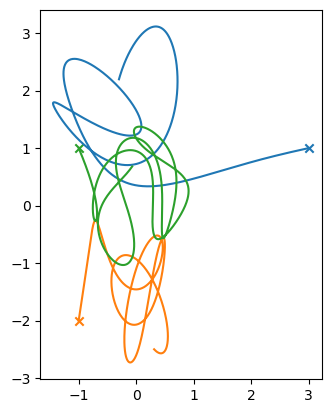

In [8]:
fig, ax = plt.subplots()

for istar in range(len(tb.M)):                                                             
    x = [star[istar].x for star in tb.stars]
    y = [star[istar].y for star in tb.stars]

    ax.plot(x, y)
    ax.scatter([x[0]], [y[0]], marker="x")
    
ax.set_aspect("equal")

Now the center of mass&mdash;since the stars started out at rest, the center of mass should not move (there are no external forces)

Text(0, 0.5, 'center of mass position')

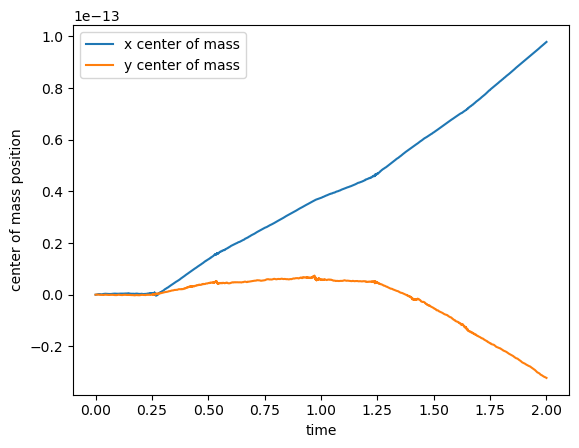

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
 
t = tb.time
x_cm = []
y_cm = []
for n in range(tb.npts()):
    _xcm, _ycm = tb.center_of_mass(n)                                                      
    x_cm.append(_xcm)                                                                      
    y_cm.append(_ycm)                                                                      

ax.plot(t, x_cm, label="x center of mass")
ax.plot(t, y_cm, label="y center of mass")

ax.legend()

ax.set_xlabel("time")
ax.set_ylabel("center of mass position")

We see that it is drifting a bit, but the numbers are close to roundoff.

Now the energy

Text(0, 0.5, 'E/E(t=0)')

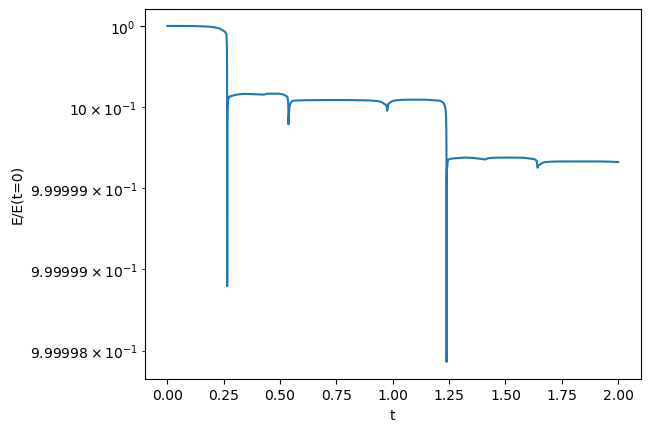

In [10]:
fig = plt.figure()
ax = fig.add_subplot()

E = []
for n in range(tb.npts()):
    E.append(tb.energy(n))                                                                 

E = np.asarray(E)

ax.plot(t, E/E[0])
    
ax.set_yscale("log")

ax.set_xlabel("t")
ax.set_ylabel("E/E(t=0)")

The energy is changing a bit over time&mdash;not unexpected.

### Softening length

What about the softening length?  Here we'll try 3 different values and we'll use different line styles to tell them apart.

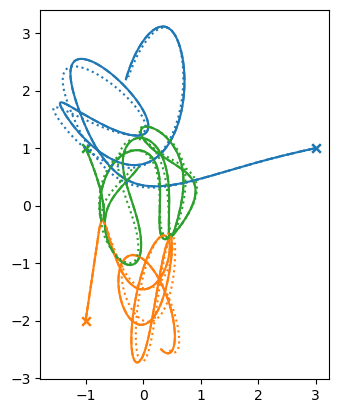

In [11]:
fig, ax = plt.subplots()

ls = ["-", "--", ":"]

for n, eps_soft in enumerate([1.e-12, 1.e-6, 1.e-4]):
    
    tb = three_body.ThreeBody(M1, p1, M2, p2, M3, p3, SMALL=eps_soft)
    tb.integrate(dt_init, eps, tmax)

    for c, istar in enumerate(range(len(tb.M))):
        x = [star[istar].x for star in tb.stars]
        y = [star[istar].y for star in tb.stars]

        ax.plot(x, y, ls=ls[n], color=f"C{c}")
        ax.scatter([x[0]], [y[0]], marker="x", color=f"C{c}")
        
ax.set_aspect("equal")

We don't see much difference between the smallest 2 choices of softening length, but the solution with the softening length of $10^{-4}$ definitely looks different.

### Initial conditions

Let's look at some more initial conditions

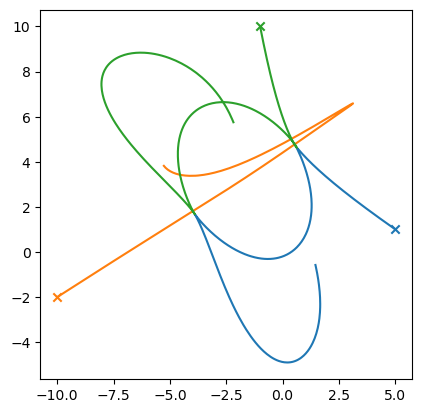

In [12]:
M1 = 100.0
p1 = (5, 1)

M2 = 100.0
p2 = (-10, -2)

M3 = 100.0
p3 = (-1, 10)

tmax = 10
eps = 1.e-8
tb = three_body.ThreeBody(M1, p1, M2, p2, M3, p3)
tb.integrate(dt_init, eps, tmax)

fig, ax = plt.subplots()

for istar in range(len(tb.M)):                                                             
    x = [star[istar].x for star in tb.stars]
    y = [star[istar].y for star in tb.stars]

    ax.plot(x, y)
    ax.scatter([x[0]], [y[0]], marker="x")
    
ax.set_aspect("equal")

<div class="alert alert-block alert-info">

**Exercise:**
    
How does the solution change if you vary the tolerance used by the adaptive step algorithm?

</div>

## Chaos

This system is [chaotic](https://en.wikipedia.org/wiki/Chaos_theory)&mdash;this means that small differences in the initial conditions can lead to very large differences in the evolution with time.

Let's see this.

We'll reintegrate our original system.

In [16]:
M1 = 150.0
p1 = (3, 1)

M2 = 200.0
p2 = (-1, -2)

M3 = 250.0
p3 = (-1, 1)

tb = three_body.ThreeBody(M1, p1, M2, p2, M3, p3)

dt_init = 0.5
tmax = 8.0

tb.integrate(dt_init, eps, tmax)

Now a small perturbation

In [17]:
M1 = 150.01
tb2 = three_body.ThreeBody(M1, p1, M2, p2, M3, p3)

tb2.integrate(dt_init, eps, tmax)

Let's just look at the evolution of star 1's x position

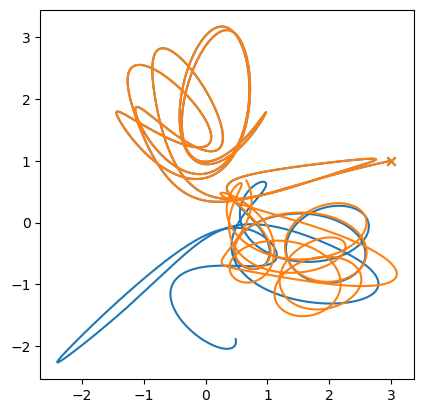

In [18]:
x = [star[0].x for star in tb.stars]
y = [star[0].y for star in tb.stars]

x2 = [star[0].x for star in tb2.stars]
y2 = [star[0].y for star in tb2.stars]

fig, ax = plt.subplots()

ax.plot(x, y)
ax.scatter([x[0]], [y[0]], marker="x")

ax.plot(x2, y2)
ax.scatter([x2[0]], [y2[0]], marker="x")

ax.set_aspect("equal")

## Going Further

* For a very large number of particles, the $N^2$ work becomes very
  computationally expensive.  The [Barnes-Hut tree
  algorithm](https://en.wikipedia.org/wiki/Barnes%E2%80%93Hut_simulation)
  reduces the work to $\mathcal{O}(N\log N)$.
  

* For large $N$, coming up with initial conditions representing a physical system is an art.  There
  are lots of papers that discuss this, such as [McMillan & Dehnen 2007](https://ui.adsabs.harvard.edu/abs/2007MNRAS.378..541M/abstract).
  
* A fun set of initial conditions for 3 equal masses is the [figure-8](https://arxiv.org/pdf/math/0011268.pdf).

* As we will see next, RK4 is not the ideal integrator for long time evolution of an N-body system.  We should try other integrators.